In [1]:
!gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
From (redirected): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8&confirm=t&uuid=602650dd-daf3-45b4-ba8e-97fae629fd14
To: /content/FER-2013.zip
100% 63.3M/63.3M [00:00<00:00, 78.0MB/s]


In [2]:
!unzip -q '/content/FER-2013.zip'

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
train_dir = '/content/train'
test_dir = '/content/test'

classes = os.listdir(train_dir)

label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls for idx, cls in label2idx.items()}

In [6]:
test_img_path = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)
print(f'Image height: {img_height}, Image width: {img_width}')

Image height: 128, Image width: 128


In [7]:
class ImageDataset(Dataset):
  def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8):
    self.resize = Resize((img_height, img_width))
    self.split = split
    self.norm = norm
    self.label2idx = label2idx
    self.train_ratio = train_ratio
    self.img_dir = img_dir
    self.label2idx = label2idx
    self.img_paths, self.img_labels = self.read_img_files()

    if split in ['train', 'val'] and 'train' in img_dir.lower():
      train_data, val_data = train_test_split(list(zip(self.img_paths, self.img_labels)),
                                              train_size=self.train_ratio,
                                              random_state=random_state,
                                              stratify=self.img_labels)
      if split == 'train':
        self.img_paths, self.img_labels = zip(*train_data)
      elif split == 'val':
        self.img_paths, self.img_labels = zip(*val_data)

  def read_img_files(self):
    img_paths = []
    img_labels = []

    for cls in self.label2idx.keys():
      for img in os.listdir(os.path.join(self.img_dir, cls)):
        img_paths.append(os.path.join(self.img_dir, cls, img))
        img_labels.append(cls)

    return img_paths, img_labels


  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    cls = self.img_labels[idx]
    img = self.resize(read_image(img_path))
    img = img.type(torch.float32)
    label = self.label2idx[cls]

    if self.norm:
      img = (img/127.5) - 1

    return img, label

In [18]:
batch_size = 256

train_dataset = ImageDataset(train_dir, norm=True, label2idx=label2idx, split='train')
val_dataset = ImageDataset(train_dir, norm=True, label2idx=label2idx, split='val')
test_dataset = ImageDataset(test_dir, norm=True, label2idx=label2idx, split='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


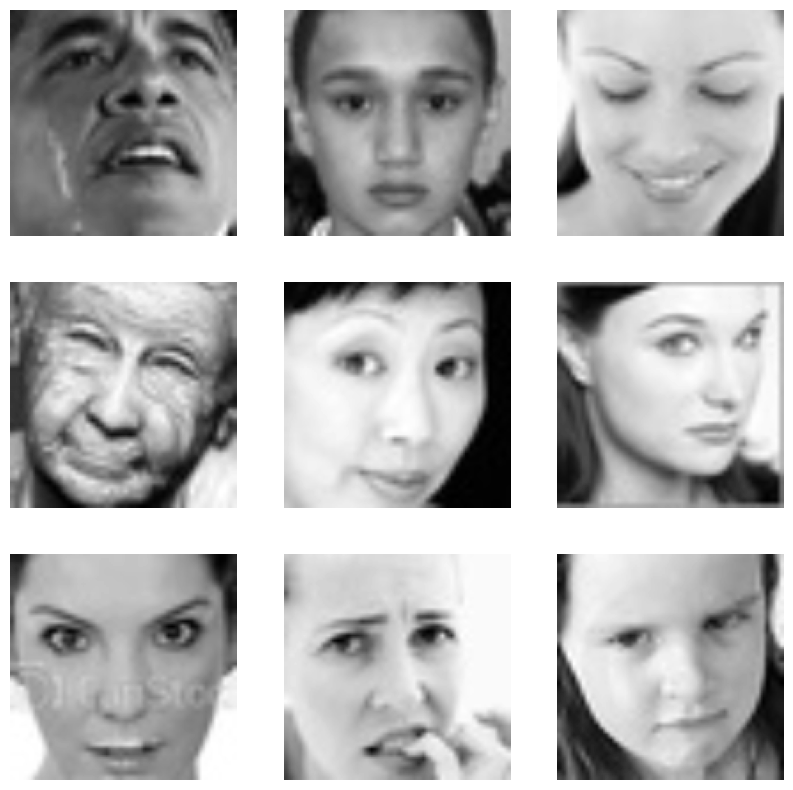

In [19]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()

    plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap='gray')
    label = label_batch[i]
    plt.axis('off')

In [15]:
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(MLP, self).__init__()
    self.linear1 = nn.Linear(input_dim, hidden_dim*4)
    self.linear2 = nn.Linear(hidden_dim*4, hidden_dim*2)
    self.linear3 = nn.Linear(hidden_dim*2, hidden_dim)
    self.output = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    x = nn.Flatten()(x)
    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)
    x = F.relu(x)
    x = self.linear3(x)
    x = F.relu(x)
    out = self.output(x)

    return out.squeeze(1)

input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(input_dim=input_dims, hidden_dim=hidden_dims, output_dim=output_dims).to(device)

In [16]:
def compute_accuracy(y_hat, y_true):
  _, y_hat = torch.max(y_hat, dim=1)
  correct = (y_hat == y_true).sum().item()
  accuracy = correct / len(y_true)
  return accuracy

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [24]:
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
  train_loss = 0.0
  train_target = []
  train_predict = []
  model.train()

  for X_samples, y_samples in train_loader:
    X_samples = X_samples.to(device)
    y_samples = y_samples.to(device)
    optimizer.zero_grad()
    outputs = model(X_samples)

    loss = criterion(outputs, y_samples)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    train_predict.append(outputs.detach().cpu())
    train_target.append(y_samples.cpu())

  train_loss /= len(train_loader)
  train_losses.append(train_loss)

  train_predict = torch.cat(train_predict)
  train_target = torch.cat(train_target)
  train_acc = compute_accuracy(train_predict, train_target)
  train_accs.append(train_acc)

  val_loss = 0.0
  val_target = []
  val_predict = []
  model.eval()
  with torch.no_grad():
    for X_samples, y_samples in val_loader:
      X_samples = X_samples.to(device)
      y_samples = y_samples.to(device)
      outputs = model(X_samples)
      val_loss += criterion(outputs, y_samples).item()

      val_predict.append(outputs.cpu())
      val_target.append(y_samples.cpu())

  val_loss /= len(val_loader)
  val_losses.append(val_loss)

  val_predict = torch.cat(val_predict)
  val_target = torch.cat(val_target)
  val_acc = compute_accuracy(val_predict, val_target)
  val_accs.append(val_acc)

  print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f} \tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 1.719 	Validation loss: 1.713

EPOCH 2:	Training loss: 1.697 	Validation loss: 1.692

EPOCH 3:	Training loss: 1.677 	Validation loss: 1.674

EPOCH 4:	Training loss: 1.661 	Validation loss: 1.661

EPOCH 5:	Training loss: 1.648 	Validation loss: 1.651

EPOCH 6:	Training loss: 1.637 	Validation loss: 1.642

EPOCH 7:	Training loss: 1.627 	Validation loss: 1.636

EPOCH 8:	Training loss: 1.617 	Validation loss: 1.628

EPOCH 9:	Training loss: 1.608 	Validation loss: 1.622

EPOCH 10:	Training loss: 1.600 	Validation loss: 1.618

EPOCH 11:	Training loss: 1.592 	Validation loss: 1.610

EPOCH 12:	Training loss: 1.584 	Validation loss: 1.608

EPOCH 13:	Training loss: 1.575 	Validation loss: 1.601

EPOCH 14:	Training loss: 1.567 	Validation loss: 1.598

EPOCH 15:	Training loss: 1.559 	Validation loss: 1.592

EPOCH 16:	Training loss: 1.551 	Validation loss: 1.589

EPOCH 17:	Training loss: 1.543 	Validation loss: 1.586

EPOCH 18:	Training loss: 1.535 	Validation loss: 1.586



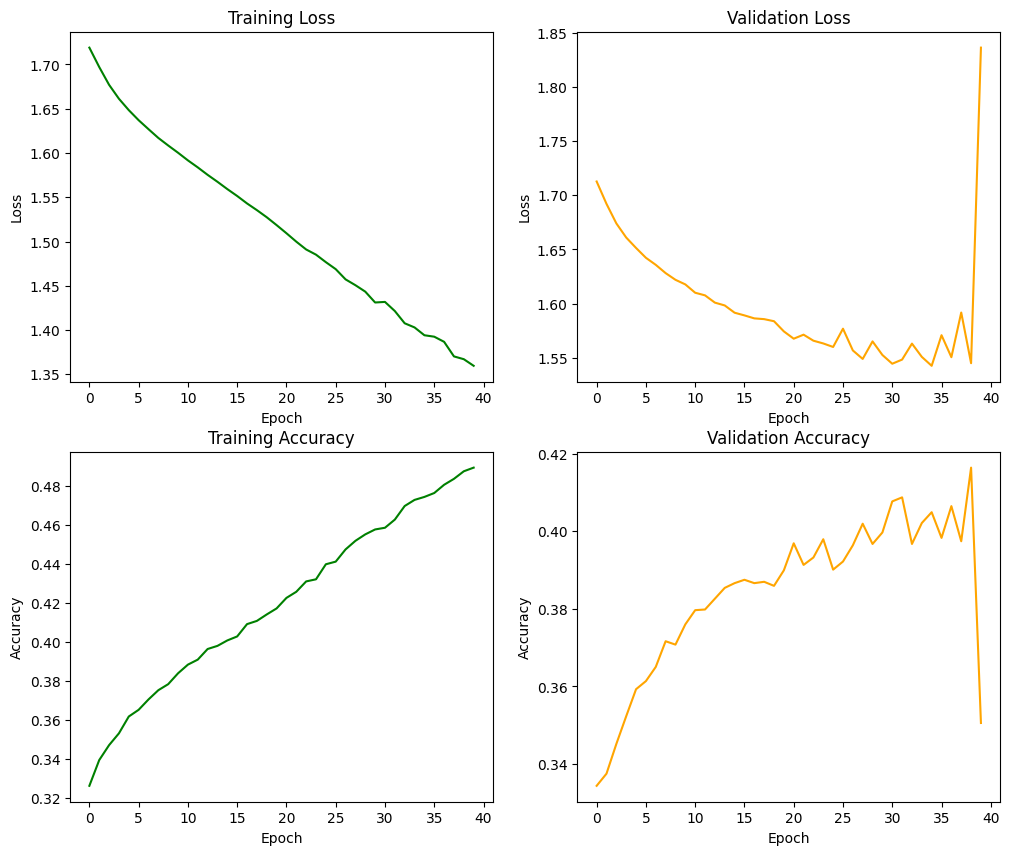

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')
ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [29]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
  for X_samples, y_samples in test_loader:
    X_samples = X_samples.to(device)
    y_samples = y_samples.to(device)
    outputs = model(X_samples)

    test_predict.append(outputs.cpu())
    test_target.append(y_samples.cpu())

  test_predict = torch.cat(test_predict)
  test_target = torch.cat(test_target)
  val_acc = compute_accuracy(test_predict, test_target)
  print('Evaluation on test set:')
  print(f'Accuracy: {val_acc}')

Evaluation on test set:
Accuracy: 0.3565059905266091
